## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Thu Dec 28 07:01:33 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0              27W /  70W |   1471MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Download video

In [ ]:
!pip install -q gdown
%cd {HOME}
!gdown '1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-'

/content
Downloading...
From: https://drive.google.com/uc?id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-
To: /content/vehicle-counting.mp4
100% 35.3M/35.3M [00:00<00:00, 265MB/s]


In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/vehicle-counting.mp4"

## Install YOLOv8

In [ ]:
!pip install ultralytics

# Mengimpor modul display dari IPython untuk membersihkan output sebelumnya
from IPython import display
display.clear_output()

# Mengimpor modul ultralytics
import ultralytics

# Memeriksa status instalasi Ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.230 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.7/78.2 GB disk)


## Install Roboflow Supervision

In [ ]:
# Instalasi modul Supervision menggunakan pip
!pip install supervision

# Mengimpor modul display dari IPython untuk membersihkan output sebelumnya
from IPython import display
display.clear_output()

# Mengimpor modul supervision dengan alias sv
import supervision as sv

# Menampilkan versi Supervision yang diinstal
print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.17.1


## Load pre-trained YOLOv8 model

In [ ]:
MODEL = "yolov8x.pt"

In [ ]:
# Mengimpor kelas YOLO dari modul ultralytics
from ultralytics import YOLO

# Membuat instance model YOLO dengan menggunakan model yang telah ditentukan sebelumnya (MODEL)
model = YOLO(MODEL)

# Melakukan operasi penyatuan (fuse) pada model
model.fuse()

YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


## Predict and annotate single frame

In [ ]:
# Kamus pemetaan class_id ke class_name
CLASS_NAMES_DICT = model.model.names

# class_ids - mobil, sepeda motor, bus, dan truk
selected_classes = [2, 3, 5, 7]

In [ ]:
import supervision as sv
import numpy as np
import cv2

In [ ]:
# Membuka video dan mengambil informasi
cap = cv2.VideoCapture(SOURCE_VIDEO_PATH)

# Mendapatkan lebar (width), tinggi (height), FPS, dan total frame dari video
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Melepas sumber daya video setelah mengambil informasi
cap.release()

# Menampilkan informasi video
print(f"Video Information: \nWidth: {width}\nHeight: {height}\nFPS: {fps}\nTotal Frames: {total_frames}")

Video Information: 
Width: 1280
Height: 720
FPS: 29.97002997002997
Total Frames: 363


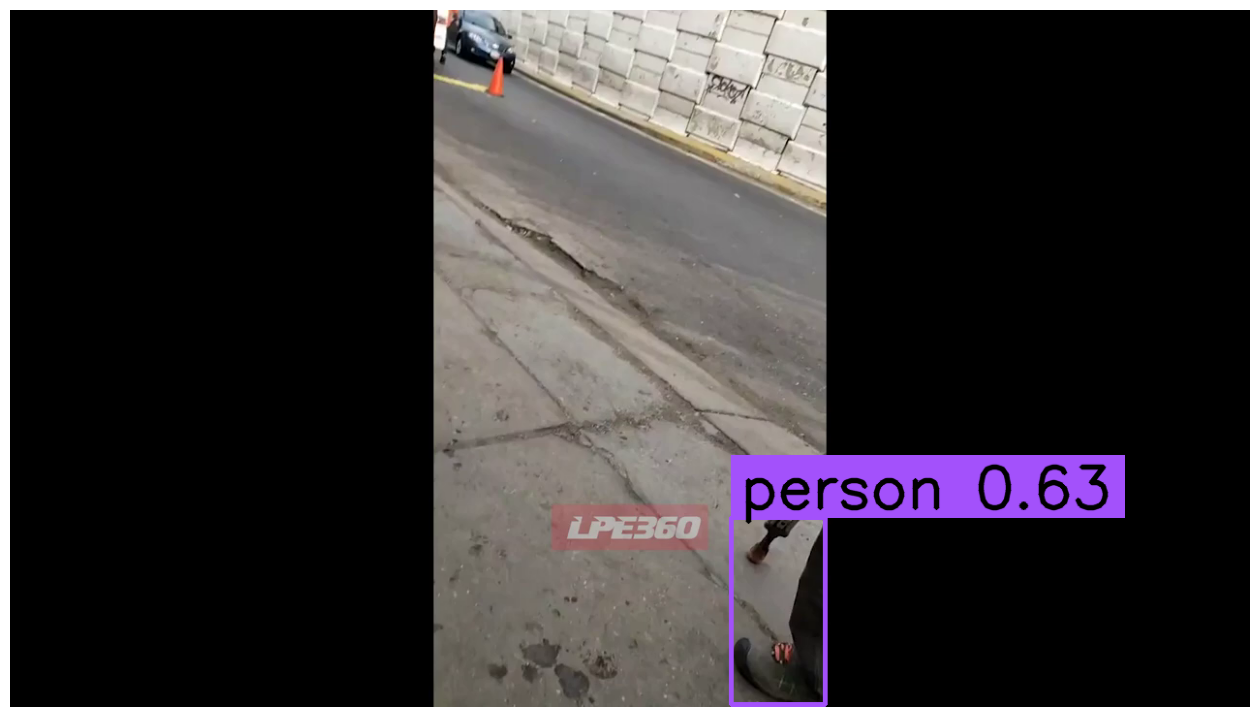

In [ ]:
# Membuat generator frame
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
# Membuat instance BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
# Mengakuisisi frame video pertama
iterator = iter(generator)
frame = next(iterator)
# Prediksi model pada satu frame dan konversi ke Supervision Detections
results = model(frame, verbose=False)[0]

# Konversi ke Detections
detections = sv.Detections.from_ultralytics(results)
# Hanya mempertimbangkan ID kelas dari selected_classes yang telah didefinisikan sebelumnya
detections = detections[np.isin(detections.class_id, selected_classes)]

# Format label kustom
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _ in detections
]

# Anotasi dan tampilkan frame
annotated_frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))


Total Detections: 7


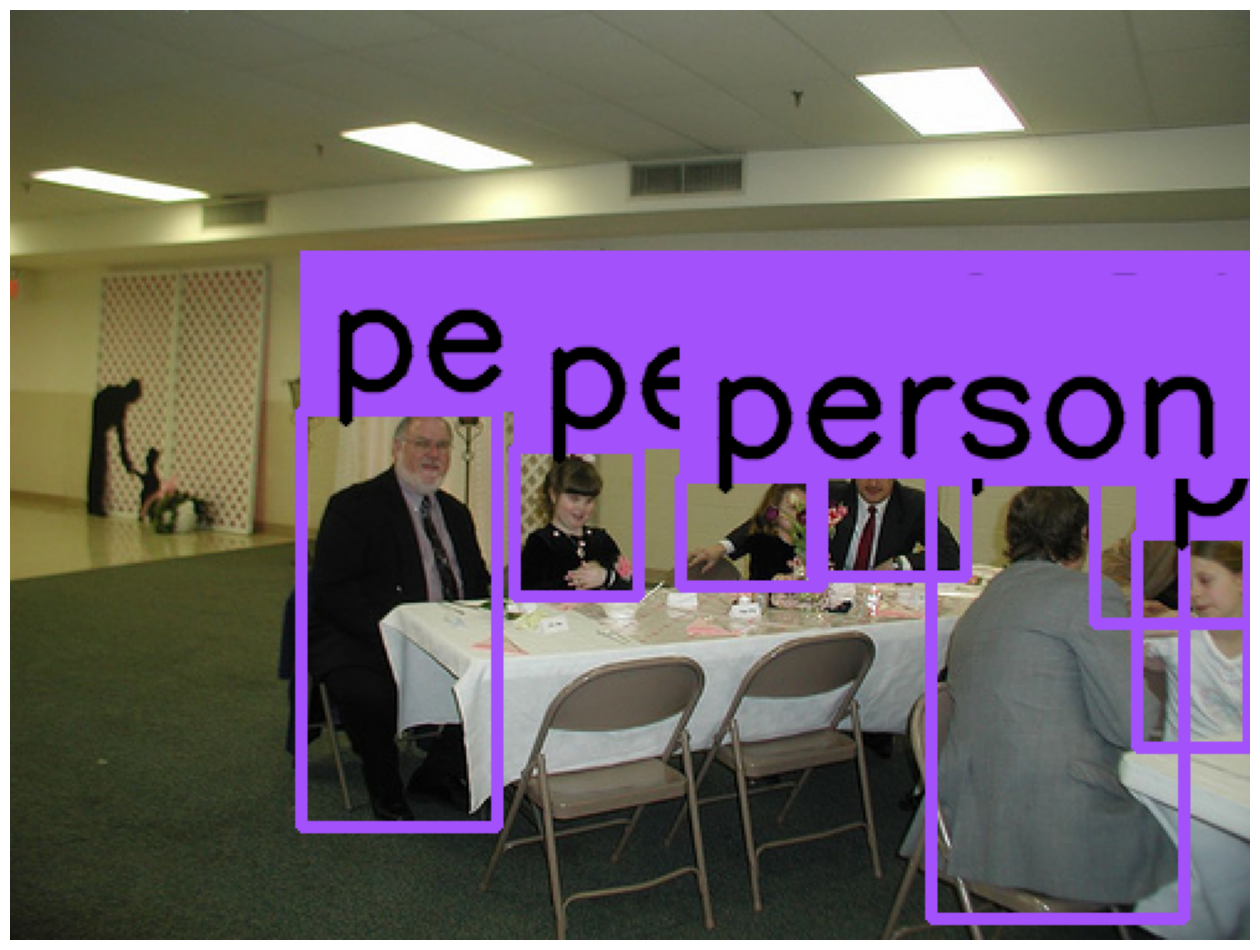

In [ ]:
SOURCE_IMAGE_PATH = f"{HOME}/image1.jpg"

# Membuat generator frame dari gambar
frame = cv2.imread(SOURCE_IMAGE_PATH)
# Prediksi model pada satu frame gambar dan konversi ke Supervision Detections
results = model(frame, verbose=False)[0]

# Konversi ke Detections
detections = sv.Detections.from_ultralytics(results)
# Hanya mempertimbangkan ID kelas dari selected_classes yang telah didefinisikan sebelumnya
detections = detections[np.isin(detections.class_id, selected_classes)]

# Format label kustom
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _ in detections
]

# Menampilkan total deteksi
total_detections = len(detections)
print(f"Total Detections: {total_detections}")

# Anotasi dan tampilkan frame gambar
annotated_frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

## Predict and annotate whole video

In [ ]:
# Line Settings
LINE_START = sv.Point(50, 1500)
LINE_END = sv.Point(3840-50, 1500)

TARGET_VIDEO_PATH = f"{HOME}/output_video.mp4"

In [ ]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1280, height=720, fps=29, total_frames=363)

In [ ]:
# Membuat instance BYTETracker
byte_tracker = sv.ByteTrack(track_thresh=0.25, track_buffer=30, match_thresh=0.8, frame_rate=30)

# Membuat instance VideoInfo
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# Membuat generator frame
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Membuat instance LineZone, sebelumnya disebut sebagai kelas LineCounter
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# Membuat instance BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)

# Membuat instance TraceAnnotator
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

# Membuat instance LineZoneAnnotator, sebelumnya disebut sebagai kelas LineCounterAnnotator
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)

# Mendefinisikan fungsi callback untuk digunakan dalam pemrosesan video
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    # Menampilkan nomor frame pada setiap frame
    video_info_text = f"Width: {width}, Height: {height}, FPS: {fps}, Frame: {index}"
    frame = cv2.putText(frame, video_info_text, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # Prediksi model pada satu frame dan konversi ke Supervision Detections
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    # Hanya mempertimbangkan ID kelas dari selected_classes yang telah didefinisikan sebelumnya
    detections = detections[np.isin(detections.class_id, selected_classes)]

    # Pelacakan deteksi
    detections = byte_tracker.update_with_detections(detections)
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"  # labeling
        for _, _, confidence, class_id, tracker_id
        in detections
    ]
    annotated_frame = trace_annotator.annotate(
        scene=frame.copy(),
        detections=detections
    )
    annotated_frame = box_annotator.annotate(
        scene=annotated_frame,
        detections=detections,
        labels=labels
    )

    # Memperbarui Line Counter
    line_zone.trigger(detections)
    # Mengembalikan frame dengan hasil annotasi kotak dan garis
    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# Memproses seluruh video
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback
)